In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch
from torch import nn

from data_generation import generate_toy_dataset, pad_sequences, \
    one_hot_encode_sequences
from utils import batch_generator, display_metrics, compare_sequences, \
    visualize_attention, calculate_loss, calculate_metric, train
from models import EncoderDecoder, EncDecAttnDotProduct, EncDecAttnBilinear, EncDecAttnConcat

%matplotlib inline

In [2]:
torch.__version__

'1.7.1'

*Замечание.* Так как `torch.tile()` нет ещё в этой версии, а более новую conda ставить не хочет, придётся как-то выкручиваться. Есть вариант заменить её использование на `torch.repeat()`.  

Зададим параметр инициализации генератора случайных чисел для возможности воспроизведения результатов экспериментов.

In [3]:
torch.manual_seed(0)
np.random.seed(1)

# Генерация данных
Для демонстрации работы Механизма Внимания воспользуемся синтетическими данными. В качестве входной последовательности будет выступать последовательность из букв латинского алфавита с повторениями, а на выходе - та же последовательность в исходном порядке.

Используемые данные нужны исключительно для демонстрации работы моделей. В реальном приложении данные могли бы представлять:
* последовательность пар предложений, где второе предложение является переводом первого на другой естественный язык (задача машинного перевода);
* последовательность пар "запрос-ответ" (чат-боты);
* большой текст и "выжимка" из него (краткое изложение содержания) и др.

Сгенерируем датасет со следующими параметрами:
* Словарь - буквы латинского алфавита. Будем считать, что токен в нашей последовательности - один символ.
* Минимальная длина последовательности - 2, максимальная - 10.
* Число записей - 15000.

In [4]:
vocabulary = np.array(list('abcdefghijklmnopqrstuvwxyz'))
print("Vocabulary:", vocabulary)

Vocabulary: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [5]:
SEQ_MAX_LEN = 10
copy_dataset = generate_toy_dataset(vocabulary, seq_min_len=2,
                                    seq_max_len=SEQ_MAX_LEN,
                                    seq_count=15000)

Посмотрим на данные:

In [6]:
copy_dataset.head()

,input,output
0,"[l, m, i, j, l, f, p]","[l, m, i, j, l, f, p]"
1,"[q, b]","[q, b]"
2,"[n, g, z, s, u, f, s, u, l]","[n, g, z, s, u, f, s, u, l]"
3,"[e, x, x, j]","[e, x, x, j]"
4,"[x, a, w]","[x, a, w]"


Теперь сформируем последовательности одинаковой длины `sequence_max_size` + 2:
* В начале каждой последовательности поставим символ `bos` (begin of sequence).
* В конце последовательности поставим символ `eos` (end of sequence). Если итоговая длина полученной последовательности получилась меньше требуемой, добавляем `eos` до тех пор, пока не получим требуемую длину.

Возникает закономерный вопрос, зачем мы это делаем.
1. Декодеру нужно сообщить о начале последовательности. Свое первое состояние декодер берет из последнего состояния энкодера, а что взять в качестве первого входного токена для декодера? Символ начала последовательности `bos`.
2. Работа декодера должна завершатся, когда сгенерирована вся последовательность. Для этого мы будем учить его предсказывать специальный символ конца последовательности `eos`. 
3. Процедура формирования последовательностей одинаковой длины необходима, так как мы хотим обучать сеть батчами, а не по одному примеру прогонять за раз.

Для обучения сети батчами нам также понадобятся бинарные маски для последовательностей. Вектор маски имеет тот же размер, что и последовательность, при этом нули в ней сооветствуют лишним символам `eos`, а единицы всем остальным символам. Данные маски понадобятся при определении лосс-функции и для реализации экодера. Бинарные маски для входной последовательности содержатся в поле `mask_inference_input`.

In [7]:
BOS = "*"
EOS = "#"
copy_dataset = pad_sequences(copy_dataset, SEQ_MAX_LEN, BOS, EOS)

In [8]:
copy_dataset.head()

,input,output,padded_input,padded_output,mask_inference_input
0,"[l, m, i, j, l, f, p]","[l, m, i, j, l, f, p]","[*, l, m, i, j, l, f, p, #, #, #, #]","[*, l, m, i, j, l, f, p, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten..."
1,"[q, b]","[q, b]","[*, q, b, #, #, #, #, #, #, #, #, #]","[*, q, b, #, #, #, #, #, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten..."
2,"[n, g, z, s, u, f, s, u, l]","[n, g, z, s, u, f, s, u, l]","[*, n, g, z, s, u, f, s, u, l, #, #]","[*, n, g, z, s, u, f, s, u, l, #, #]","[tensor(True), tensor(True), tensor(True), ten..."
3,"[e, x, x, j]","[e, x, x, j]","[*, e, x, x, j, #, #, #, #, #, #, #]","[*, e, x, x, j, #, #, #, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten..."
4,"[x, a, w]","[x, a, w]","[*, x, a, w, #, #, #, #, #, #, #, #]","[*, x, a, w, #, #, #, #, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten..."


Работать с символами напрямую мы не можем, переводим символы в числа. Закодируем символы следующим образом:
* bos закодируем числом 0;
* eos закодируем числом 1;
* все остальные символы закодируем по порядку.

In [9]:
BOS_CODE = 0
EOS_CODE = 1
sym2num = {sym: i+2 for i, sym in enumerate(vocabulary)}
sym2num.update({BOS: BOS_CODE, EOS: EOS_CODE})

Теперь вместо последовательности токенов фиксированной длины получим последовательность фиксированной длины из чисел и произведем One Hot кодирование этой числовой последовательности.

Всего в закодированной исходной числовой последовательности `N=28` различных чисел (2 для специальных символов и 26 для символов алфавита). Для каждого числа `x` в исходной последовательности поставим в соответствие вектор размерности 28 из нулей и одной единицы на позиции = числу `x`.

Пусть, например, мы кодируем последовательность `[*, a, #, #]` или `[0, 2, 1, 1]`, причем `N=4`. Тогда число `x=0` будем кодировать вектором `[1, 0, 0, 0]`, `x=1` вектором `[0, 1, 0, 0]`, `x=2` вектором `[0, 0, 1, 0]`.
Полученные векторы сложим в одну матрицу и получим 
`[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]` - закодированную последовательность.

In [10]:
copy_dataset = one_hot_encode_sequences(copy_dataset, sym2num)
copy_dataset.head()

,input,output,padded_input,padded_output,mask_inference_input,one_hot_input,one_hot_output
0,"[l, m, i, j, l, f, p]","[l, m, i, j, l, f, p]","[*, l, m, i, j, l, f, p, #, #, #, #]","[*, l, m, i, j, l, f, p, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[q, b]","[q, b]","[*, q, b, #, #, #, #, #, #, #, #, #]","[*, q, b, #, #, #, #, #, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[n, g, z, s, u, f, s, u, l]","[n, g, z, s, u, f, s, u, l]","[*, n, g, z, s, u, f, s, u, l, #, #]","[*, n, g, z, s, u, f, s, u, l, #, #]","[tensor(True), tensor(True), tensor(True), ten...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[e, x, x, j]","[e, x, x, j]","[*, e, x, x, j, #, #, #, #, #, #, #]","[*, e, x, x, j, #, #, #, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[x, a, w]","[x, a, w]","[*, x, a, w, #, #, #, #, #, #, #, #]","[*, x, a, w, #, #, #, #, #, #, #, #]","[tensor(True), tensor(True), tensor(True), ten...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


В данном случае мы не воспользовались методами класса <a href=https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html>OneHotEncoder</a> из `sklearn.preprocessing` с целью пошаговой подробной демонстрации происходящего. Разумеется, когда вы будете решать не учебные задачи, вам нужно будет пользоваться уже готовыми реализациями. Также вряд ли вам когда-либо надо будет иметь дело с one-hot векторами напрямую, а не с их sparse-версиями (возможность создания sparse векторов также есть у `OneHotEncoder`).

Произведем разбиение датасета на обучающую выборку, валидацию и тест.

In [11]:
train_data, test_data = train_test_split(copy_dataset, test_size=0.25,
                                         random_state=10)
val_data, test_data = train_test_split(test_data, test_size=0.25,
                                       random_state=11)

Отметим также, что для обучения рекуррентых сетей батчами в pytorch есть специальные функции:
1. <a href=https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html>pad_sequence</a>: позволяет получать последовательности одинаковой длины в батче.
2. <a href=https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence>pack_padded_sequence</a>: позволяет не совершать лишних итераций рекуррентной сети.

<a href=https://stackoverflow.com/a/55805785/12919840>Тут</a> можно почитать про это.

# Модель Encoder-Decoder

Базовый класс `BaseEncoderDecoder` определен в файле `model.py`.
1. Кодирование (`self.encode`) исходной последовательности осуществляется при помощи линейного слоя `self.embedding`. Обратите внимание на параметры этого линейного слоя (какая входная размерность векторов, какая выходная).
   * Матрица весов слоя `self.embedding` умножается на закодированную one-hot последовательность, что позволяет перейти от бинарных векторов для токенов к действительным векторам.
   * Эта операция может быть весьма затратной в той реализации, которая представлена здесь. Дело в том, что словарь для реальных данных обычно состоит не из 26 токенов (+2 токена bos и eos), а из десятков тысяч токенов. В этом случае каждый one-hot вектор для токена будет содержать десятки тысяч значений, и матрица весов слоя `self.embedding` будет перемножаться с вектором большой размерности, что весьма вычислительно затратно.
   * С другой стороны, зачем нам вообще нужны one-hot вектора и матричное умножение? Ведь умножение one-hot вектора на матрицу равносильно просто выбору строки из данной матрицы. Слой <a href=https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html>Embedding</a> из `torch.nn` именно это и делает. При решении не учебной задачи можно воспользоваться <a href=https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder>OrdinalEncoder</a> из `sklearn.preprocessing` для кодирования токенов в натуральные числа, а в самой сети добавить слой `Embedding` (см. документацию).
2. В коде, где происходит генерация скрытых состояний кодируемой последовательности присутствует такая строчка:
```
# save new state for not eos tokens, otherwise save prev state
state = torch.where(
    torch.tile(mask_inference_inputs[:, i, None],
               [1, next_state.shape[1]]),
    next_state, state
)
```
Зачем нужен этот код? Впишите свой ответ в ячейке ниже.

<b>Ответ:</b> 

Сначала разберёмся, что там вообще происходит. Код `mask_inference_inputs[:, i, None]` извлекает значение маски для соответствующего эмбеддингу символа, результат имеет размер `[batch_size, 1]`. Код `torch.tile(mask_inference_inputs[:, i, None], [1, next_state.shape[1]])` дублирует значения массива по осям следующим образом: `[1, hidden_size]`, то есть теперь размер результата `[batch_size, hidden_size]`, причём вдоль последней оси растянуто значение маски. Таким образом, если значение маски для элемента из батча `True`, то возьмутся все элементы `next_state`, и иначе ---  элементы `state`. Т. е. если `EOS` уже был, мы перестаём обновлять `hidden_state` у генерируемых символов, тем самым зацикливаясь и генерируя `EOS`.

Нужно это за тем, чтобы после сгенерированного `EOS` перестать кодировать ещё какую-то информацию о паддингах, оставляя только информацию о последовательности. Более того, если паддинг очень большой относительно исходной последовательности, то encoder вообще может почти не уловить какой-то информации о ней, "запомнив" только кучу паддингов.

In [12]:
# Примерчик работы

state = np.array([[1, 2, 3], [2, 4, 6]])
next_state = np.array([[3, 1, 2], [9, 1, 4]])
mask = np.array([[True, False, False], [True, True, True]], dtype=np.bool)
i = 1

print(mask[:, i, None])
hehe = np.tile(mask[:, i, None], [1, next_state.shape[1]])
print(hehe)

np.where(hehe, next_state, state)

[[False]
 [ True]]
[[False False False]
 [ True  True  True]]


array([[1, 2, 3],
       [9, 1, 4]])

3. Как видно из кода модели, декодирование в режиме обучения (когда `self.training` == True) и режиме инференса (в противном случае) осуществляется при помощи разных методов (`self.decode_training` и `self.decode_eval`). Почему? Впишите свой ответ в ячейке ниже.

<b>Ответ:</b>

Потому что в режиме обучения у нас есть target последовательность, которую мы используем как вход для следующей ячейки RNN. А вот в тестовом режиме таргета нет, поэтому используются ответы с предыдущей итерации.

Вообще можно было бы и не разделять методы, но тогда сеть гораздо сильнее ошибалась бы в процессе обучения, дольше обучалась бы.

4. Какая используется стратегия декодирования на этапе инференса? Какие еще стратегии декодирования вы знаете?

<b>Ответ:</b>

Используется стратегия жадного выбора, т. е. на каждом этапе предсказаний берётся вариант с наибольшей вероятностью.

Как минимум, есть ещё 2 стратегии. Первая --- sampling, когда предсказание выбирается рандомно из k возможных предсказаний с наибольшей вероятностью. Вторая --- beam search, в котором на каждом этапе генерируется k предсказаний и для каждого из этапов далее тоже так, а в конце выбирается лучшее из всех вариантов.

5. На вход энкодеру приходит вектор размерности `embed_size + len(mapping)`. Почему? Какие дополнительные признаки были добавлены к эмбеддинговым признакам в коде?

<b>Ответ:</b>

Лучше сначала ответить на второй вопрос, потом на первый. В качестве дополнительных признаков были добавлены one-hot представления первых `seq_max_len` символов из алфавита. Непонятно, зачем это нам...

Я знаю, что добавляют one-hot представления позиции символа в строке (positional encoding), так как attention размывает информацию о порядке слов. Но тогда матрица должна быть размера `embed_size + seq_max_len`...

## Без Механизма Внимания

Определим первую модель, с которой проведем эксперимент. Это обычная модель Encoder-Decoder без использования Механизма Внимания.

In [13]:
enc_dec_model = EncoderDecoder(sym2num, BOS, EOS, embed_size=50,
                               enc_hidden_size=70, dec_hidden_size=70)
optimizer = torch.optim.Adam(enc_dec_model.parameters())

Для оценки качества модели воспользуемся расстоянием Левенштейна, деленным на максимальную длину из длин истинной или предсказанной последовательности. Чем меньше расстояние между этими последовательностями, тем модель делает более точные предсказания.

Всю информацию о процессе обучения смотри в файле `utils.py`, функция `train`.

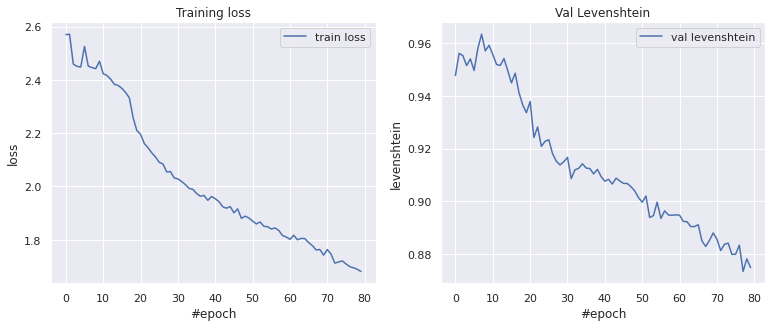

CPU times: user 10min 4s, sys: 7.43 s, total: 10min 11s
Wall time: 5min 18s


In [14]:
%%time


try:
    train(enc_dec_model, train_data, val_data, optimizer, SEQ_MAX_LEN,
          batch_size=50, epochs_count=80)
except KeyboardInterrupt:
    pass

In [15]:
# Сделаем чекпоинт
torch.save(enc_dec_model.state_dict(), 'model_without_atten_80epochs.pt')

Посмотрим на предсказания:

In [16]:
compare_sequences(enc_dec_model, val_data, SEQ_MAX_LEN)

predicted sequences:
 [['f', 'q', 'j'], ['e', 't', 'u'], ['m', 'w'], ['q', 'z', 'v', 'e', 'v', 'g', 'a']]
true sequences:
 [[['k', 'm', 'c']], [['w', 't', 'o']], [['m', 'w']], [['u', 'p', 'q', 'v', 'c', 'm', 's']]]


<b>Домашняя работа:</b>
1. Проведите несколько экспериментов с данной моделью. Саму модель не надо менять, меняйте параметры оптимизатора, число эпох обучения и размер батча.
2. Получите качество лучшей модели на тестовой выборке.
3. Сделайте выводы, в которых в том числе отметьте: сколько эпох потребовалось для обучения, какое финальное качество модели вы получили.

*Замечание.* Сначала поэксперементируем с качеством для различных вариаций, а потом обучим заново исходную. Также отметим, что менять число эпох особого смысла нет: чем больше, тем лучше. Разве что переобучение может помешать, но мы находимся в условиях обучения на CPU, так что эпох немного...

In [12]:
from tqdm import tqdm

In [13]:
# TODO: попробовать scorch
# TODO: как написать красиво, чтобы графики оставались?(

# def parameter_tuning(model_class):  
#     epochs_cnt = 30
#     learning_rates = [0.001, 0.01, 0.1]
#     batch_sizes = [25, 100]
    
#     for lr in tqdm(learning_rates):
#         enc_dec_model_for_testing = model_class(
#             sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, 
#             dec_hidden_size=70
#         )
#         optimizers = [
#             torch.optim.AdamW(enc_dec_model_for_testing.parameters(), lr=lr), 
#             torch.optim.SGD(enc_dec_model_for_testing.parameters(), lr=lr, 
#                             momentum=0.8, nesterov=True), 
#             torch.optim.RMSprop(enc_dec_model_for_testing.parameters(), lr=lr, 
#                                 momentum=0.8)
#         ]
        
#         for optimizer in optimizers:
#             for batch_size in batch_sizes:
#                 train(enc_dec_model_for_testing, train_data, val_data, 
#                       optimizer, SEQ_MAX_LEN, batch_size=batch_size, 
#                       epochs_count=epochs_cnt)
#             print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", 
#                   optimizer)

epochs_cnt = 30
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [25, 100]

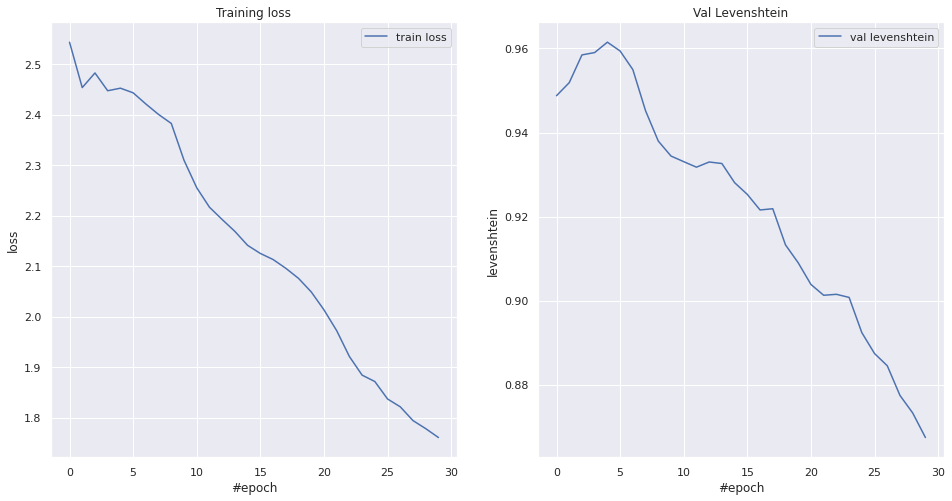

lr = 0.001, batch_size = 25, optimizer = AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
CPU times: user 6min 22s, sys: 4.88 s, total: 6min 26s
Wall time: 3min 18s


In [14]:
%%time

lr = learning_rates[0]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.AdamW(enc_dec_model_for_testing.parameters(), lr=lr)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

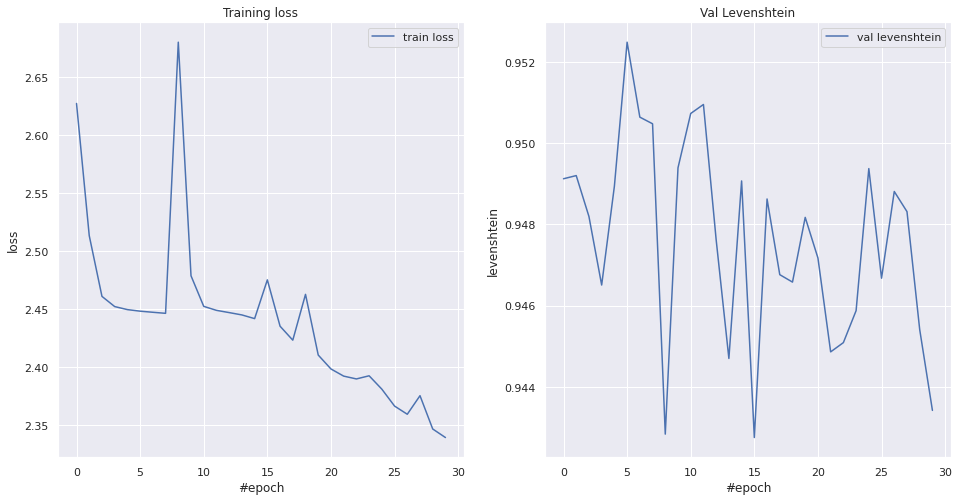

lr = 0.001, batch_size = 100, optimizer = AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
CPU times: user 2min 40s, sys: 2.22 s, total: 2min 42s
Wall time: 1min 25s


In [17]:
%%time

lr = learning_rates[0]
batch_size = batch_sizes[1]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.AdamW(enc_dec_model_for_testing.parameters(), lr=lr)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

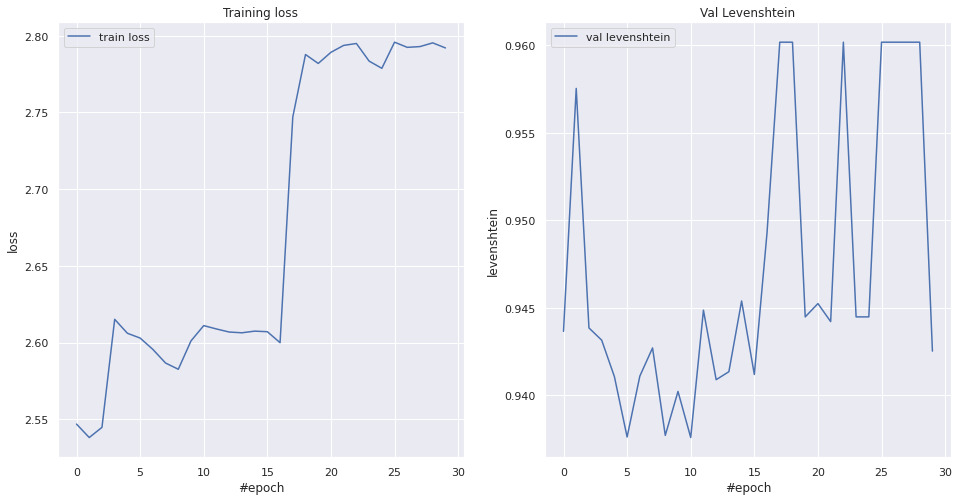

lr = 0.01, batch_size = 25, optimizer = AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0.01
)
CPU times: user 6min 35s, sys: 5 s, total: 6min 40s
Wall time: 3min 26s


In [18]:
%%time

lr = learning_rates[1]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.AdamW(enc_dec_model_for_testing.parameters(), lr=lr)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

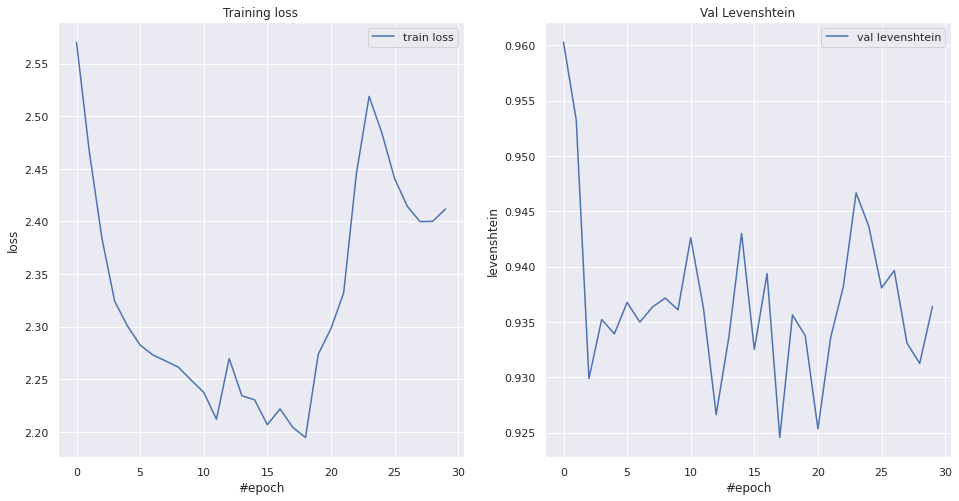

lr = 0.01, batch_size = 100, optimizer = AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0.01
)
CPU times: user 2min 28s, sys: 1.67 s, total: 2min 30s
Wall time: 1min 19s


In [19]:
%%time

lr = learning_rates[1]
batch_size = batch_sizes[1]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.AdamW(enc_dec_model_for_testing.parameters(), lr=lr)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

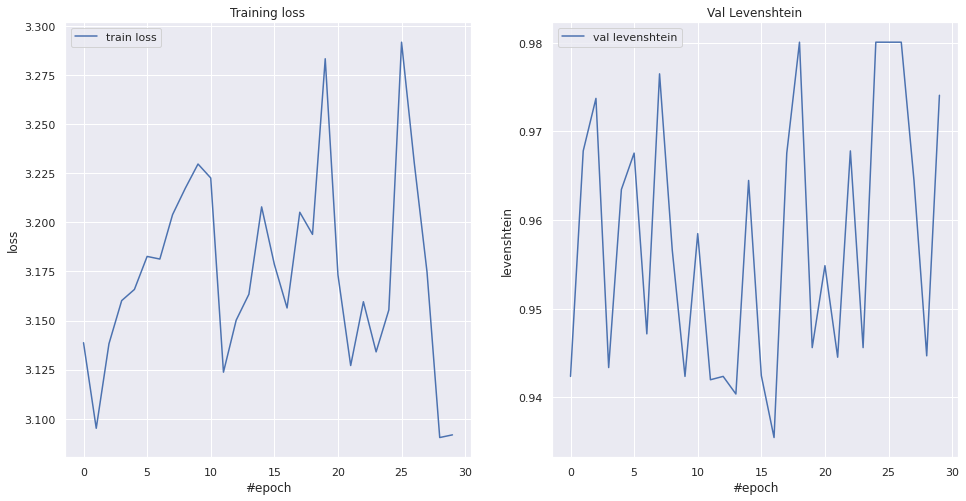

lr = 0.1, batch_size = 25, optimizer = AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0.01
)
CPU times: user 6min 33s, sys: 5.46 s, total: 6min 39s
Wall time: 3min 24s


In [20]:
%%time

lr = learning_rates[2]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.AdamW(enc_dec_model_for_testing.parameters(), lr=lr)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

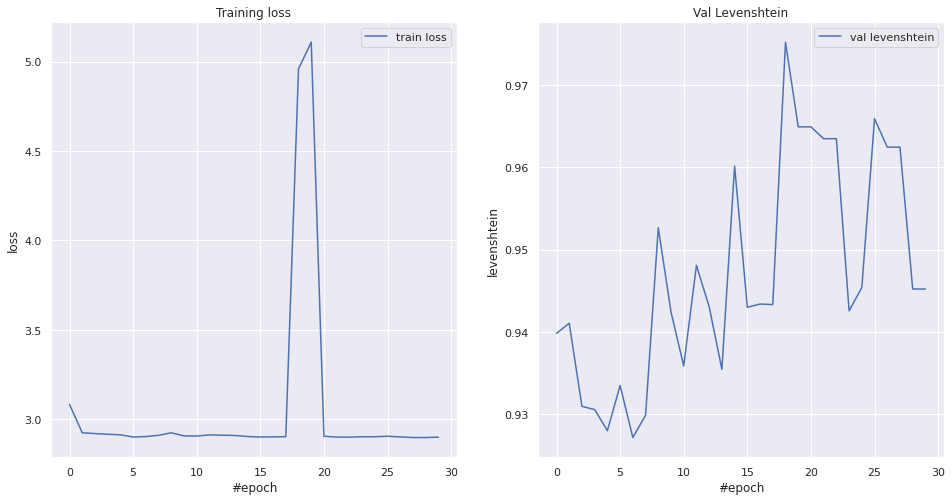

lr = 0.1, batch_size = 100, optimizer = AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0.01
)
CPU times: user 2min 45s, sys: 2.34 s, total: 2min 47s
Wall time: 1min 28s


In [21]:
%%time

lr = learning_rates[2]
batch_size = batch_sizes[1]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.AdamW(enc_dec_model_for_testing.parameters(), lr=lr)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

**Минивывод.** `batch_size = 100` большой, лучше заменить на 50, `larning_rate = 0.1` большой, лучше уберём его и добавим `learning_rate = 0.0001`.

In [22]:
epochs_cnt = 30
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [25, 50]

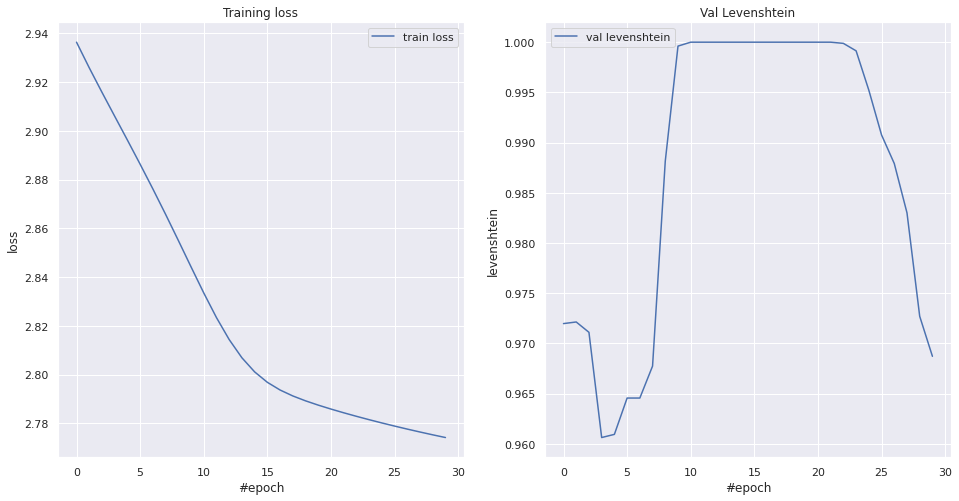

lr = 0.0001, batch_size = 25, optimizer = SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.8
    nesterov: True
    weight_decay: 0
)
CPU times: user 6min 22s, sys: 5.61 s, total: 6min 27s
Wall time: 4min 23s


In [23]:
%%time

lr = learning_rates[0]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.SGD(enc_dec_model_for_testing.parameters(), lr=lr, 
                            momentum=0.8, nesterov=True)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

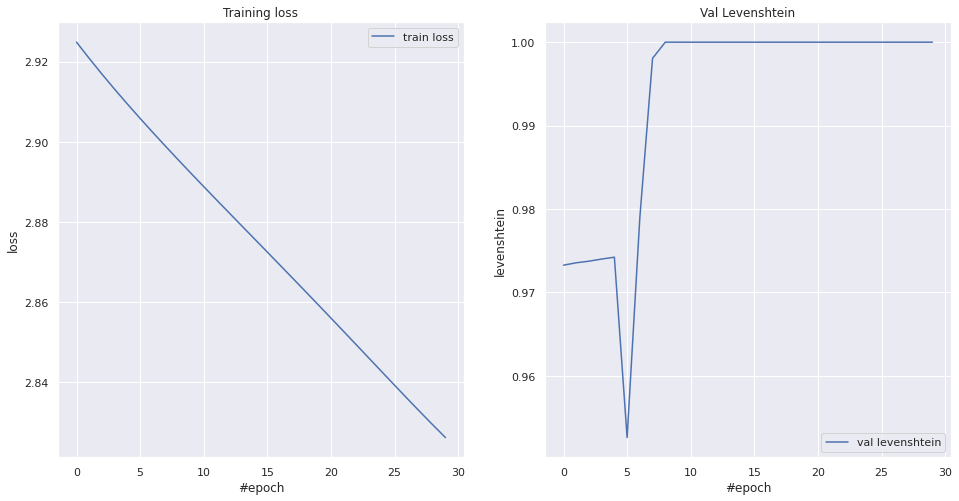

lr = 0.0001, batch_size = 50, optimizer = SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.8
    nesterov: True
    weight_decay: 0
)
CPU times: user 3min 59s, sys: 3.42 s, total: 4min 2s
Wall time: 2min 10s


In [24]:
%%time

lr = learning_rates[0]
batch_size = batch_sizes[1]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.SGD(enc_dec_model_for_testing.parameters(), lr=lr, 
                            momentum=0.8, nesterov=True)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

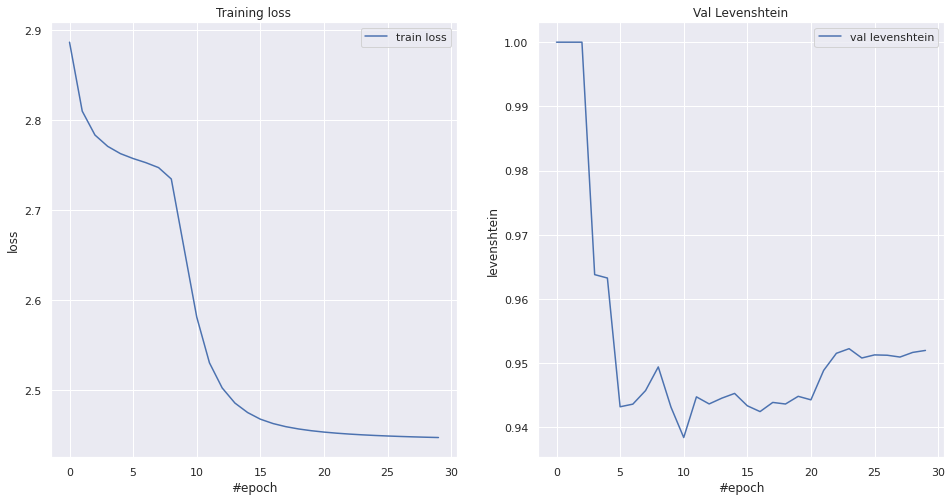

lr = 0.001, batch_size = 25, optimizer = SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.8
    nesterov: True
    weight_decay: 0
)
CPU times: user 6min 29s, sys: 5.43 s, total: 6min 35s
Wall time: 3min 26s


In [25]:
%%time

lr = learning_rates[1]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.SGD(enc_dec_model_for_testing.parameters(), lr=lr, 
                            momentum=0.8, nesterov=True)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

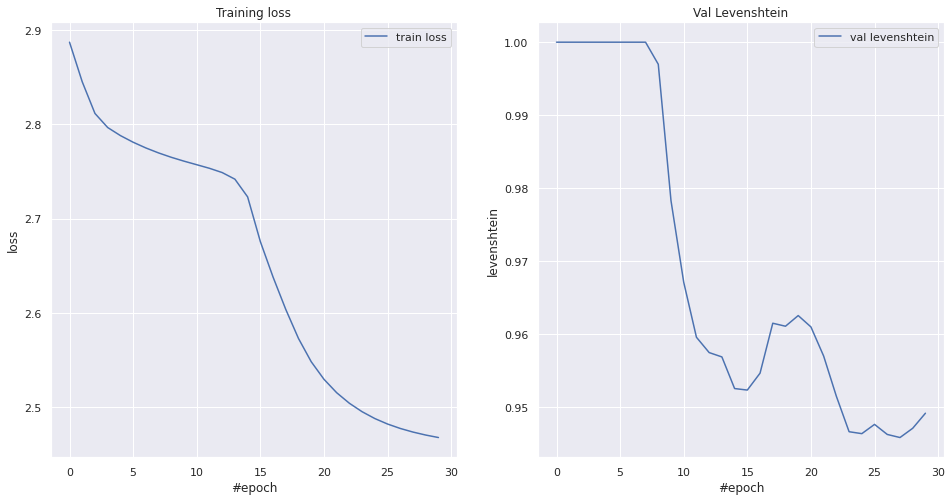

lr = 0.001, batch_size = 50, optimizer = SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.8
    nesterov: True
    weight_decay: 0
)
CPU times: user 3min 48s, sys: 2.59 s, total: 3min 51s
Wall time: 1min 59s


In [26]:
%%time

lr = learning_rates[1]
batch_size = batch_sizes[1]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.SGD(enc_dec_model_for_testing.parameters(), lr=lr, 
                            momentum=0.8, nesterov=True)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

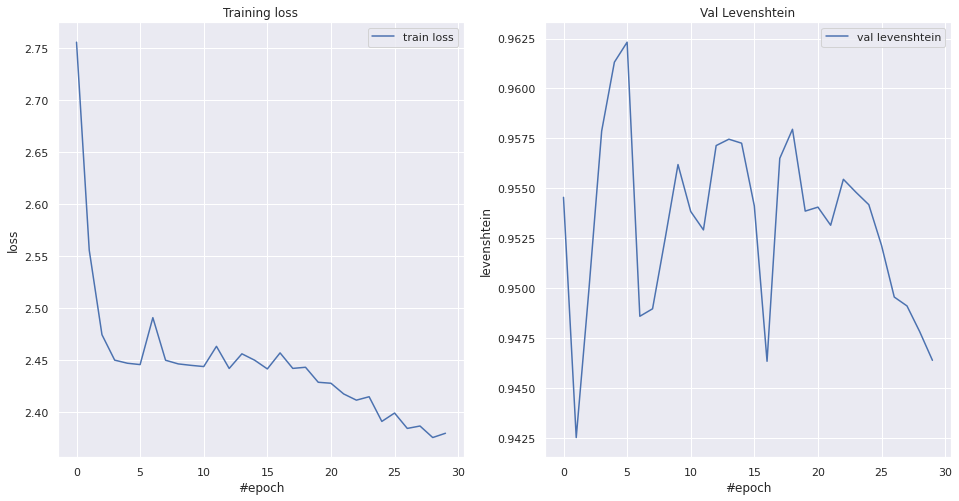

lr = 0.01, batch_size = 25, optimizer = SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.8
    nesterov: True
    weight_decay: 0
)
CPU times: user 6min 27s, sys: 5.32 s, total: 6min 32s
Wall time: 3min 21s


In [27]:
%%time

lr = learning_rates[2]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.SGD(enc_dec_model_for_testing.parameters(), lr=lr, 
                            momentum=0.8, nesterov=True)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

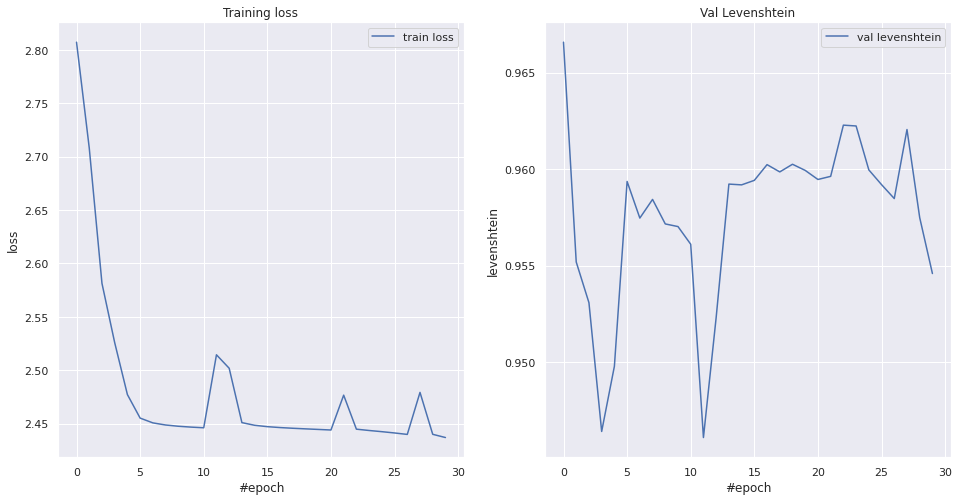

lr = 0.01, batch_size = 50, optimizer = SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.8
    nesterov: True
    weight_decay: 0
)
CPU times: user 3min 50s, sys: 3 s, total: 3min 53s
Wall time: 2min 2s


In [28]:
%%time

lr = learning_rates[2]
batch_size = batch_sizes[1]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.SGD(enc_dec_model_for_testing.parameters(), lr=lr, 
                            momentum=0.8, nesterov=True)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

**Минивывод.** Интересно, для разных оптимизаторов разные "хорошие" порядки `learning_rate`. А ещё можно сказать, что меньшее число батчей лучше влияет на сходимость, зато время работы увеличивается.

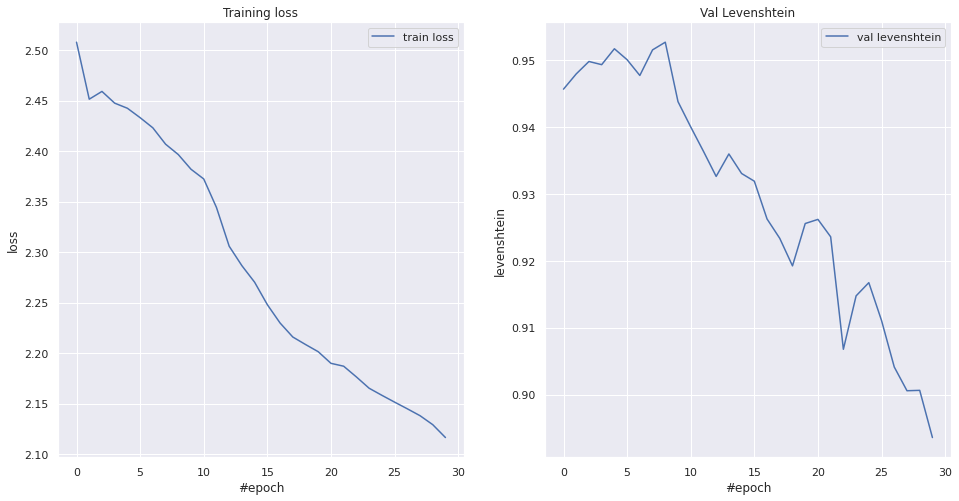

lr = 0.0001, batch_size = 25, optimizer = RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0001
    momentum: 0.8
    weight_decay: 0
)
CPU times: user 6min 28s, sys: 5.32 s, total: 6min 33s
Wall time: 3min 21s


In [30]:
%%time

lr = learning_rates[0]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.RMSprop(enc_dec_model_for_testing.parameters(), lr=lr, 
                                momentum=0.8)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

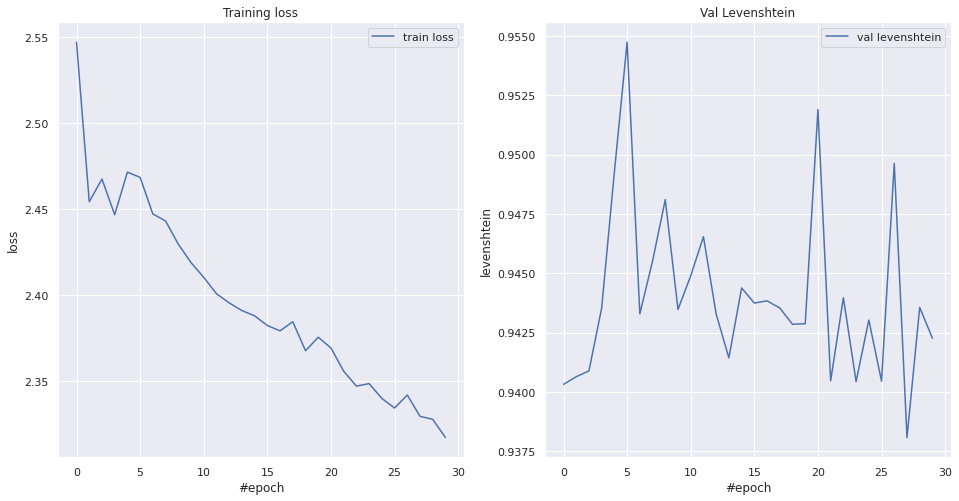

lr = 0.0001, batch_size = 50, optimizer = RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0001
    momentum: 0.8
    weight_decay: 0
)
CPU times: user 3min 53s, sys: 2.8 s, total: 3min 56s
Wall time: 2min 3s


In [34]:
%%time

lr = learning_rates[0]
batch_size = batch_sizes[1]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.RMSprop(enc_dec_model_for_testing.parameters(), lr=lr, 
                                momentum=0.8)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

**Минивывод.** Тут закономерность с размером батчей повторяется, так что дальше оставим только `batch_size = 25`.

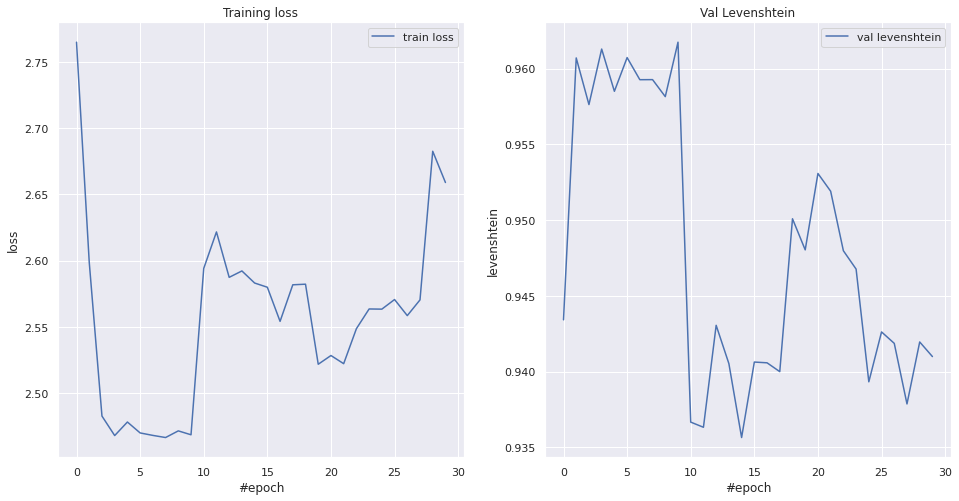

lr = 0.001, batch_size = 25, optimizer = RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0.8
    weight_decay: 0
)
CPU times: user 6min 10s, sys: 4.62 s, total: 6min 15s
Wall time: 3min 11s


In [35]:
%%time

lr = learning_rates[1]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.RMSprop(enc_dec_model_for_testing.parameters(), lr=lr, 
                                momentum=0.8)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

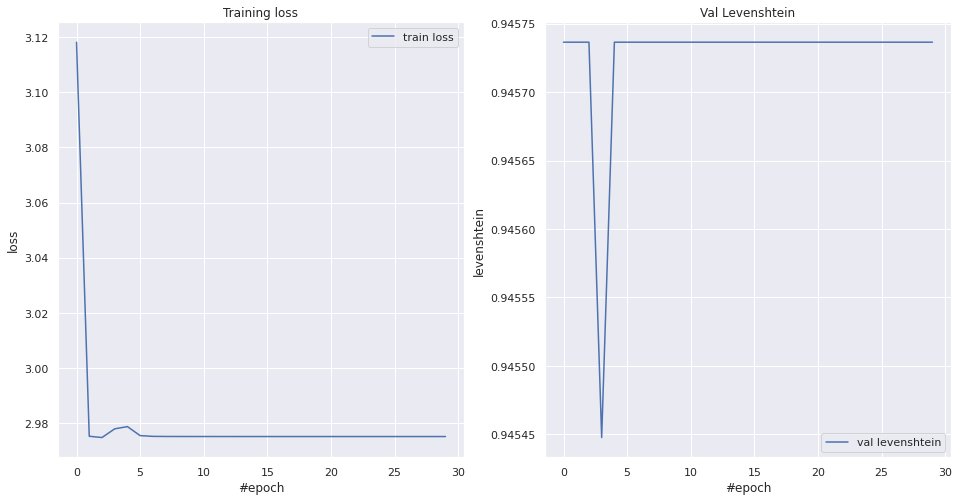

lr = 0.01, batch_size = 25, optimizer = RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0.8
    weight_decay: 0
)
CPU times: user 6min 53s, sys: 5.88 s, total: 6min 59s
Wall time: 3min 35s


In [36]:
%%time

lr = learning_rates[2]
batch_size = batch_sizes[0]

enc_dec_model_for_testing = EncoderDecoder(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70, dec_hidden_size=70
)
optimizer = torch.optim.RMSprop(enc_dec_model_for_testing.parameters(), lr=lr, 
                                momentum=0.8)

train(
    enc_dec_model_for_testing, train_data, val_data, optimizer, 
    SEQ_MAX_LEN, batch_size=batch_size, epochs_count=epochs_cnt
)
print(f"lr = {lr}, batch_size = {batch_size}, optimizer =", optimizer)

**Минивывод.** Были перебраны параметры `learning rate, batch size`, а также оптимизаторы. Не совсем ясна ситуация с `Adam vs AdamW`, так как использовались разные `batch_size`. Проверим это отдельно.

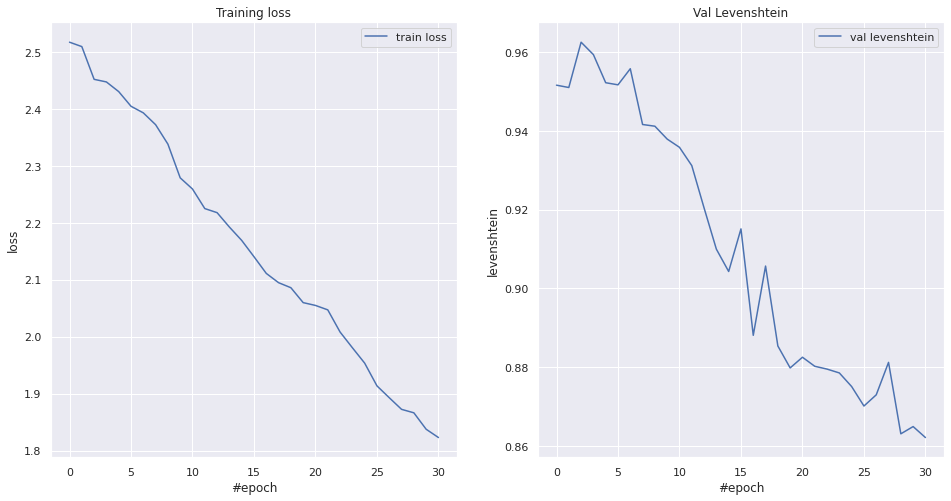

CPU times: user 6min 30s, sys: 4.87 s, total: 6min 35s
Wall time: 3min 22s


In [38]:
%%time


enc_dec_model = EncoderDecoder(sym2num, BOS, EOS, embed_size=50,
                               enc_hidden_size=70, dec_hidden_size=70)
optimizer = torch.optim.Adam(enc_dec_model.parameters())

try:
    train(enc_dec_model, train_data, val_data, optimizer, SEQ_MAX_LEN,
          batch_size=25, epochs_count=30)
except KeyboardInterrupt:
    pass

**Вывод.** Итак, наилучшие результаты показала конфигурация: 

lr = 0.001, batch_size = 25, 
optimizer = AdamW (
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

Обучим её ниже и сохраним.

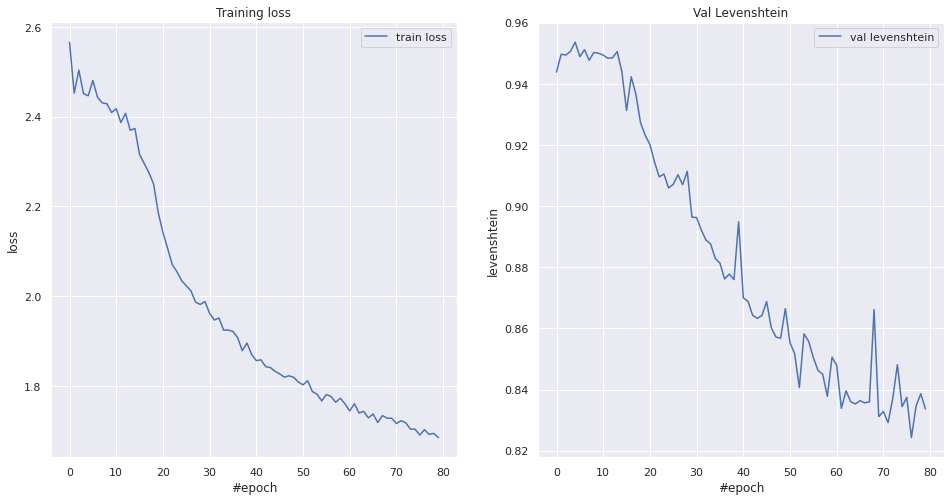

CPU times: user 10min 1s, sys: 6.86 s, total: 10min 7s
Wall time: 5min 15s


In [42]:
%%time


enc_dec_model = EncoderDecoder(sym2num, BOS, EOS, embed_size=50,
                               enc_hidden_size=70, dec_hidden_size=70)
optimizer = torch.optim.AdamW(enc_dec_model.parameters())

try:
    train(enc_dec_model, train_data, val_data, optimizer, SEQ_MAX_LEN,
          batch_size=50, epochs_count=80)
except KeyboardInterrupt:
    pass

In [43]:
# Сделаем чекпоинт
torch.save(enc_dec_model.state_dict(), 'best_model_without_atten_80epochs.pt')

Теперь давайте добавим Механизм Внимания.

## С добавлением Механизма Внимания

<b>Домашняя работа</b>: реализовать требуемые классы в файле `models.py` и обучить модели.

Перед реализацией моделей посмотри код для визуализации весов Внимания: файл `utils.py`, функция  `visualize_attention`.
В коде моделей есть `attn_weights` поле, которое вы должны заполнить.

### Скалярное произведение (Dot-Product)
Реализуйте Encoder-Decoder сеть с Механизмом Внимания в виде простого скалярного произведения (класс `EncDecAttnDotProduct`).
$$logit_i = <enc_{i}, dec>, $$
где $i \in \overline{0, N_{e}}$, $N_{e}$ - число состояний энкодера.

<b>! Обратите внимание</b>, что полученные логиты еще не являются весами Внимания. Для получения весов нужно:
1. Наложить бинарную маску: те логиты, которые относятся к дополнительным `eos` токенам приравняйте к $-\infty$, т.е. к $-10^{9}$.
2. Применить Softmax.

In [ ]:
enc_dec_dot_product = EncDecAttnDotProduct(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70,
    dec_hidden_size=70)
optimizer = torch.optim.Adam(enc_dec_dot_product.parameters(), lr=0.0005)

In [ ]:
try:
    train(enc_dec_dot_product, train_data, val_data, optimizer, SEQ_MAX_LEN,
          batch_size=50, epochs_count=5)
except KeyboardInterrupt:
    pass

In [ ]:
compare_sequences(enc_dec_dot_product, val_data, SEQ_MAX_LEN)

In [ ]:
visualize_attention(enc_dec_dot_product, val_data, SEQ_MAX_LEN, BOS, EOS,
                    batch_size=2)

<b>Домашняя работа:</b>
1. Проведите несколько экспериментов с данной моделью. Саму модель не надо менять, меняйте параметры оптимизатора, число эпох обучения и размер батча.
2. Получите качество лучшей модели на тестовой выборке.
3. Визуализируйте веса Внимания лучшей модели.
4. Сделайте выводы, в которых в том числе отметьте: сколько эпох потребовалось для обучения, какое финальное качество модели вы получили. Лучше ли данная модель с точки зрения определенной метрики на тестовой выборки, чем Encoder-Decoder без внимания? Отличается ли число параметров текущей модели от числа параметров модели без внимания? О чем это говорит?

### Билинейное Внимание

Реализуйте Encoder-Decoder сеть с Механизмом Внимания в следующем виде (класс `EncDecAttnBilinear`):
1. К состоянию энкодера применяется линейное преобразование.
2. Затем считается скалярное произведение между обновленным состоянием энкодера и состоянием декодера.

$$logit_i = <linear(enc_{i}), dec>, $$
где $i \in \overline{0, N_{e}}$, $N_{e}$ - число состояний энкодера.

<b>! Обратите внимание</b>, что полученные логиты еще не являются весами Внимания. Для получения весов нужно:
1. Наложить бинарную маску: те логиты, которые относятся к дополнительным `eos` токенам приравняйте к $-\infty$, т.е. к $-10^{9}$.
2. Применить Softmax.

In [ ]:
enc_dec_bilinear = EncDecAttnBilinear(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70,
    dec_hidden_size=70)
optimizer = torch.optim.Adam(enc_dec_bilinear.parameters(), lr=0.0005)

In [ ]:
try:
    train(enc_dec_bilinear, train_data, val_data, optimizer, SEQ_MAX_LEN,
          batch_size=50, epochs_count=11)
except KeyboardInterrupt:
    pass

In [ ]:
compare_sequences(enc_dec_bilinear, val_data, SEQ_MAX_LEN)

In [ ]:
visualize_attention(enc_dec_bilinear, val_data, SEQ_MAX_LEN, BOS, EOS,
                    batch_size=2)

<b>Домашняя работа:</b>
1. Проведите несколько экспериментов с данной моделью. Саму модель не надо менять, меняйте параметры оптимизатора, число эпох обучения и размер батча.
2. Получите качество лучшей модели на тестовой выборке.
3. Визуализируйте веса Внимания лучшей модели.
4. Сделайте выводы, в которых в том числе отметьте: сколько эпох потребовалось для обучения, какое финальное качество модели вы получили.

### Конкатенакция

Реализуйте Encoder-Decoder сеть с Механизмом Внимания в следующем виде (класс `EncDecAttnConcat`):
1. Состояние энкодера конкатенируется с состоянием декодера.
2. Применяется линейный слой (выходная размерность вектора = `dec_hidden_size`).
3. Применяется тангенс гиперболический.
4. Осуществляется скалярное произведение с обучаемым вектором.

$$concat_i = concatenate(enc_{i}, dec)$$
$$logit_i = <tanh(linear(concat_i)), vec>$$
где $i \in \overline{0, N_{e}}$, $N_{e}$ - число состояний энкодера.

<b>! Обратите внимание</b>, что полученные логиты еще не являются весами Внимания. Для получения весов нужно:
1. Наложить бинарную маску: те логиты, которые относятся к дополнительным `eos` токенам приравняйте к $-\infty$, т.е. к $-10^{9}$.
2. Применить Softmax.

In [ ]:
enc_dec_concat = EncDecAttnConcat(
    sym2num, BOS, EOS, embed_size=50, enc_hidden_size=70,
    dec_hidden_size=70)
optimizer = torch.optim.Adam(enc_dec_concat.parameters(), lr=0.0005)

In [ ]:
try:
    train(enc_dec_concat, train_data, val_data, optimizer, SEQ_MAX_LEN,
          batch_size=50, epochs_count=15)
except KeyboardInterrupt:
    pass

In [ ]:
compare_sequences(enc_dec_concat, val_data, SEQ_MAX_LEN)

In [ ]:
visualize_attention(enc_dec_concat, val_data, SEQ_MAX_LEN, BOS, EOS, batch_size=2)

<b>Домашняя работа:</b>
1. Проведите несколько экспериментов с данной моделью. Саму модель не надо менять, меняйте параметры оптимизатора, число эпох обучения и размер батча.
2. Получите качество лучшей модели на тестовой выборке.
3. Визуализируйте веса Внимания лучшей модели.
4. Сделайте выводы, в которых в том числе отметьте: сколько эпох потребовалось для обучения, какое финальное качество модели вы получили.